#DATA CLEANING

In [ ]:
import warnings
warnings.filterwarnings('ignore')
# Import the numpy, pandas, datetime, matplotlib, & seaborn packages

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Create a spark session

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('NYC Parking Data Analysis').getOrCreate()
# Read the csv file

parking_df = spark.read.format("csv")\
                  .option("header", "true")\
                  .option("inferSchema", "true")\
                  .load("/content/drive/MyDrive/Parking_Violations_Issued_-_Fiscal_Year_2022.csv")

parking_df

DataFrame[Summons Number: bigint, Plate ID: string, Registration State: string, Plate Type: string, Issue Date: string, Violation Code: int, Vehicle Body Type: string, Vehicle Make: string, Issuing Agency: string, Street Code1: int, Street Code2: int, Street Code3: int, Vehicle Expiration Date: int, Violation Location: int, Violation Precinct: int, Issuer Precinct: int, Issuer Code: int, Issuer Command: string, Issuer Squad: string, Violation Time: string, Time First Observed: string, Violation County: string, Violation In Front Of Or Opposite: string, House Number: string, Street Name: string, Intersecting Street: string, Date First Observed: int, Law Section: int, Sub Division: string, Violation Legal Code: string, Days Parking In Effect: string, From Hours In Effect: string, To Hours In Effect: string, Vehicle Color: string, Unregistered Vehicle?: int, Vehicle Year: int, Meter Number: string, Feet From Curb: int, Violation Post Code: string, Violation Description: string, No Standin

In [ ]:
# Show the schema for datatypes

parking_df.printSchema()

root
 |-- Summons Number: long (nullable = true)
 |-- Plate ID: string (nullable = true)
 |-- Registration State: string (nullable = true)
 |-- Plate Type: string (nullable = true)
 |-- Issue Date: string (nullable = true)
 |-- Violation Code: integer (nullable = true)
 |-- Vehicle Body Type: string (nullable = true)
 |-- Vehicle Make: string (nullable = true)
 |-- Issuing Agency: string (nullable = true)
 |-- Street Code1: integer (nullable = true)
 |-- Street Code2: integer (nullable = true)
 |-- Street Code3: integer (nullable = true)
 |-- Vehicle Expiration Date: integer (nullable = true)
 |-- Violation Location: integer (nullable = true)
 |-- Violation Precinct: integer (nullable = true)
 |-- Issuer Precinct: integer (nullable = true)
 |-- Issuer Code: integer (nullable = true)
 |-- Issuer Command: string (nullable = true)
 |-- Issuer Squad: string (nullable = true)
 |-- Violation Time: string (nullable = true)
 |-- Time First Observed: string (nullable = true)
 |-- Violation Coun

In [ ]:
# Check for the number of rows 

parking_df.count()



15435607

In [ ]:
# Check for number of columns

len(parking_df.columns)

43

In [ ]:
# Display the first 5 rows of data

parking_df.show(5)

+--------------+--------+------------------+----------+----------+--------------+-----------------+------------+--------------+------------+------------+------------+-----------------------+------------------+------------------+---------------+-----------+--------------+------------+--------------+-------------------+----------------+---------------------------------+------------+------------------+-------------------+-------------------+-----------+------------+--------------------+----------------------+--------------------+------------------+-------------+---------------------+------------+------------+--------------+-------------------+---------------------+---------------------------------+-----------------+------------------------+
|Summons Number|Plate ID|Registration State|Plate Type|Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Issuing Agency|Street Code1|Street Code2|Street Code3|Vehicle Expiration Date|Violation Location|Violation Precinct|Issuer Precinct|Issuer C

In [ ]:
# Show the statistics

parking_df.describe().show()

In [ ]:
# Replace ' ' with '_' in column headers so as to avoid any issues while using the queries...

parking_df = parking_df.toDF(*(colName.replace(' ', '_') for colName in parking_df.columns))
parking_df.show(5)

+--------------+--------+------------------+----------+----------+--------------+-----------------+------------+--------------+------------+------------+------------+-----------------------+------------------+------------------+---------------+-----------+--------------+------------+--------------+-------------------+----------------+---------------------------------+------------+------------------+-------------------+-------------------+-----------+------------+--------------------+----------------------+--------------------+------------------+-------------+---------------------+------------+------------+--------------+-------------------+---------------------+---------------------------------+-----------------+------------------------+
|Summons_Number|Plate_ID|Registration_State|Plate_Type|Issue_Date|Violation_Code|Vehicle_Body_Type|Vehicle_Make|Issuing_Agency|Street_Code1|Street_Code2|Street_Code3|Vehicle_Expiration_Date|Violation_Location|Violation_Precinct|Issuer_Precinct|Issuer_C

In [ ]:
import pyspark.sql.functions as F
# Check for missing/null values in each column
null_cols = parking_df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in parking_df.columns]).toPandas()

# Print column names with missing/null values
for col in null_cols.columns:
    if null_cols[col][0] > 0:
        print(f"{col} column has {null_cols[col][0]} missing values")


Vehicle_Body_Type column has 33128 missing values
Vehicle_Make column has 10689 missing values
Violation_Location column has 6035566 missing values
Issuer_Command column has 6030198 missing values
Issuer_Squad column has 6424789 missing values
Violation_Time column has 177 missing values
Time_First_Observed column has 14643865 missing values
Violation_County column has 37194 missing values
Violation_In_Front_Of_Or_Opposite column has 6097273 missing values
House_Number column has 6164206 missing values
Street_Name column has 1517 missing values
Intersecting_Street column has 7990868 missing values
Sub_Division column has 2165 missing values
Violation_Legal_Code column has 9405407 missing values
Days_Parking_In_Effect column has 6150607 missing values
From_Hours_In_Effect column has 10441351 missing values
To_Hours_In_Effect column has 10441373 missing values
Vehicle_Color column has 1019839 missing values
Unregistered_Vehicle? column has 15118764 missing values
Meter_Number column has 

In [ ]:
# Set the threshold for missing values
threshold = 0.9

# Get the total number of rows in the DataFrame
total_rows = parking_df.count()

# Get the names of columns with missing values exceeding the threshold
cols_to_drop = []
for col in null_cols.columns:
    if null_cols[col][0] / total_rows > threshold:
        cols_to_drop.append(col)

# Drop the columns with missing values exceeding the threshold
parking_df_1 = parking_df.drop(*cols_to_drop)


In [ ]:
# Print the columns dropped
print("Columns dropped:")
for col in cols_to_drop:
    print(col)



Columns dropped:
Time_First_Observed
Unregistered_Vehicle?
No_Standing_or_Stopping_Violation
Hydrant_Violation
Double_Parking_Violation


In [ ]:
# Print the columns of the new DataFrame
print("\nColumns of the new DataFrame:")
for col in parking_df_1.columns:
    print(col)


Columns of the new DataFrame:
Summons_Number
Plate_ID
Registration_State
Plate_Type
Issue_Date
Violation_Code
Vehicle_Body_Type
Vehicle_Make
Issuing_Agency
Street_Code1
Street_Code2
Street_Code3
Vehicle_Expiration_Date
Violation_Location
Violation_Precinct
Issuer_Precinct
Issuer_Code
Issuer_Command
Issuer_Squad
Violation_Time
Violation_County
Violation_In_Front_Of_Or_Opposite
House_Number
Street_Name
Intersecting_Street
Date_First_Observed
Law_Section
Sub_Division
Violation_Legal_Code
Days_Parking_In_Effect
From_Hours_In_Effect
To_Hours_In_Effect
Vehicle_Color
Vehicle_Year
Meter_Number
Feet_From_Curb
Violation_Post_Code
Violation_Description


In [ ]:
"""# Remove null values

# Check the count before dropping null values
print('Count before dropping null values : ', parking_df.count())

# drop null values
parking_df = parking_df.na.drop()

# Check the count after dropping the null values
print('Count after dropping null values  : ', parking_df.count())"""

"# Remove null values\n\n# Check the count before dropping null values\nprint('Count before dropping null values : ', parking_df.count())\n\n# drop null values\nparking_df = parking_df.na.drop()\n\n# Check the count after dropping the null values\nprint('Count after dropping null values  : ', parking_df.count())"

In [ ]:
# Drop duplicate values based on the summons number column

# Check the count before dropping duplicate summon numbers
print('Count before dropping duplicate summon numbers : ', parking_df_1.count())

# drop duplicate summon numbers
parking_df_1.select('Summons_Number').dropDuplicates()

# Check the count after dropping duplicate summon numbers
print('Count before dropping duplicate summon numbers : ', parking_df_1.count())

Count before dropping duplicate summon numbers :  15435607
Count before dropping duplicate summon numbers :  15435607


In [ ]:
# Print the schema to view the data types of all columns
parking_df_1.printSchema()

# Print the first 5 values of a column and its datatype
column_name = 'Vehicle_Body_Type'
print(f"\nFirst 5 values of '{column_name}' column and its datatype:")
parking_df_1.select(column_name).show(5)
parking_df_1.select(column_name).printSchema()

column_name_2 = 'Vehicle_Make'
print(f"\nFirst 5 values of '{column_name}' column and its datatype:")
parking_df_1.select(column_name_2).show(5)
parking_df_1.select(column_name_2).printSchema()

column_name_3 = 'Violation_Location'
print(f"\nFirst 5 values of '{column_name}' column and its datatype:")
parking_df_1.select(column_name_3).show(5)
parking_df_1.select(column_name_3).printSchema()


root
 |-- Summons_Number: long (nullable = true)
 |-- Plate_ID: string (nullable = true)
 |-- Registration_State: string (nullable = true)
 |-- Plate_Type: string (nullable = true)
 |-- Issue_Date: string (nullable = true)
 |-- Violation_Code: integer (nullable = true)
 |-- Vehicle_Body_Type: string (nullable = true)
 |-- Vehicle_Make: string (nullable = true)
 |-- Issuing_Agency: string (nullable = true)
 |-- Street_Code1: integer (nullable = true)
 |-- Street_Code2: integer (nullable = true)
 |-- Street_Code3: integer (nullable = true)
 |-- Vehicle_Expiration_Date: integer (nullable = true)
 |-- Violation_Location: integer (nullable = true)
 |-- Violation_Precinct: integer (nullable = true)
 |-- Issuer_Precinct: integer (nullable = true)
 |-- Issuer_Code: integer (nullable = true)
 |-- Issuer_Command: string (nullable = true)
 |-- Issuer_Squad: string (nullable = true)
 |-- Violation_Time: string (nullable = true)
 |-- Violation_County: string (nullable = true)
 |-- Violation_In_Fron

In [ ]:
parking_df_1 = parking_df_1.fillna({'Issuer_Command': 'unknown'})


In [ ]:
from pyspark.sql.functions import col

mode = parking_df_1.select(col('Vehicle_Color')).groupBy('Vehicle_Color').count().orderBy('count', ascending=False).first()[0]
parking_df_1 = parking_df_1.fillna({'Vehicle_Color': mode})


In [ ]:
column_name_4 = 'Violation_Time'
print(f"\nFirst 5 values of '{column_name_4}' column and its datatype:")
parking_df_1.select(column_name_4).show(5)
parking_df_1.select(column_name_4).printSchema()



First 5 values of 'Violation_Time' column and its datatype:
+--------------+
|Violation_Time|
+--------------+
|         0130A|
|         0225A|
|         0809P|
|         0605P|
|         1058P|
+--------------+
only showing top 5 rows

root
 |-- Violation_Time: string (nullable = true)



In [ ]:
from pyspark.sql.functions import col
from pyspark.sql.window import Window
from pyspark.sql import functions as F

# Fill missing values with '0'
parking_df_1 = parking_df_1.fillna({'Violation_Time': '0'})

# Convert to timestamp
parking_df_1 = parking_df_1.withColumn('Violation_Timestamp',
    F.to_timestamp(parking_df_1['Violation_Time'], 'hhmma')
)

# Create a window to order by date
w = Window.partitionBy('Plate_ID').orderBy('Violation_Timestamp')

# Fill remaining missing values using linear interpolation
parking_df_1 = parking_df_1.withColumn('Violation_Timestamp',
    F.when(col('Violation_Timestamp') == '0', None).otherwise(col('Violation_Timestamp'))
).withColumn('Violation_Timestamp', F.last('Violation_Timestamp', True).over(w)).fillna({'Violation_Timestamp': '0'})

"""we first fill missing values with '0', then convert the 'Violation_Time' column to a timestamp using the to_timestamp function. We then create a window to order the dataframe by date and use the last function to fill remaining missing values using linear interpolation. Finally, we fill any remaining missing values with '0'."""

"we first fill missing values with '0', then convert the 'Violation_Time' column to a timestamp using the to_timestamp function. We then create a window to order the dataframe by date and use the last function to fill remaining missing values using linear interpolation. Finally, we fill any remaining missing values with '0'."

In [ ]:
#parking_df_1 = parking_df_1.dropna()


In [ ]:
parking_df_1.show(5)

+--------------+--------+------------------+----------+----------+--------------+-----------------+------------+--------------+------------+------------+------------+-----------------------+------------------+------------------+---------------+-----------+--------------+------------+--------------+----------------+---------------------------------+------------+--------------+-------------------+-------------------+-----------+------------+--------------------+----------------------+--------------------+------------------+-------------+------------+------------+--------------+-------------------+---------------------+-------------------+
|Summons_Number|Plate_ID|Registration_State|Plate_Type|Issue_Date|Violation_Code|Vehicle_Body_Type|Vehicle_Make|Issuing_Agency|Street_Code1|Street_Code2|Street_Code3|Vehicle_Expiration_Date|Violation_Location|Violation_Precinct|Issuer_Precinct|Issuer_Code|Issuer_Command|Issuer_Squad|Violation_Time|Violation_County|Violation_In_Front_Of_Or_Opposite|House

In [ ]:
"""# Check columns with missing values again
missing_values_count = parking_df_1.select([count(when(col(c).isNull(), c)).alias(c) for c in parking_df_1.columns])
missing_columns = [c for c in missing_values_count.columns if missing_values_count.collect()[0][c] > 0]

# Print columns with missing values
if len(missing_columns) > 0:
    print("Columns with missing values:")
    for column in missing_columns:
        print(column)
else:
    print("No missing values in any column.")"""


'# Check columns with missing values again\nmissing_values_count = parking_df_1.select([count(when(col(c).isNull(), c)).alias(c) for c in parking_df_1.columns])\nmissing_columns = [c for c in missing_values_count.columns if missing_values_count.collect()[0][c] > 0]\n\n# Print columns with missing values\nif len(missing_columns) > 0:\n    print("Columns with missing values:")\n    for column in missing_columns:\n        print(column)\nelse:\n    print("No missing values in any column.")'

In [ ]:
"""# Check2 columns with missing values again
missing_values_count = parking_df_1.select([count(when(col(c).isNull(), c)).alias(c) for c in parking_df_1.columns])
missing_columns = [c for c in missing_values_count.columns if missing_values_count.collect()[0][c] > 0]

# Print columns with missing values
if len(missing_columns) > 0:
    print("Columns with missing values:")
    for column in missing_columns:
        print(column)
else:
    print("No missing values in any column.")"""


'# Check2 columns with missing values again\nmissing_values_count = parking_df_1.select([count(when(col(c).isNull(), c)).alias(c) for c in parking_df_1.columns])\nmissing_columns = [c for c in missing_values_count.columns if missing_values_count.collect()[0][c] > 0]\n\n# Print columns with missing values\nif len(missing_columns) > 0:\n    print("Columns with missing values:")\n    for column in missing_columns:\n        print(column)\nelse:\n    print("No missing values in any column.")'

In [ ]:
# Import necessary libraries
from pyspark.sql.functions import when

# Deal with Issuer_Squad column
parking_df_1 = parking_df_1.fillna({'Issuer_Squad': 'Unknown'})

# Deal with Violation_Time column
parking_df_1 = parking_df_1.fillna({'Violation_Time': '0'})
parking_df_1 = parking_df_1.fillna({'Violation_Timestamp': '0'})
parking_df_1 = parking_df_1.withColumn('Violation_Timestamp', when(parking_df_1['Violation_Timestamp'] == '0', None).otherwise(parking_df_1['Violation_Timestamp']))
parking_df_1 = parking_df_1.withColumn('Violation_Time', when(parking_df_1['Violation_Time'] == '0', None).otherwise(parking_df_1['Violation_Time']))

# Deal with Violation_County column
parking_df_1 = parking_df_1.fillna({'Violation_County': 'Unknown'})

# Deal with Violation_In_Front_Of_Or_Opposite column
parking_df_1 = parking_df_1.fillna({'Violation_In_Front_Of_Or_Opposite': 'Unknown'})

# Deal with House_Number column
parking_df_1 = parking_df_1.fillna({'House_Number': 'Unknown'})

# Deal with Street_Name column
parking_df_1 = parking_df_1.fillna({'Street_Name': 'Unknown'})

# Deal with Intersecting_Street column
parking_df_1 = parking_df_1.fillna({'Intersecting_Street': 'Unknown'})

# Deal with Sub_Division column
parking_df_1 = parking_df_1.fillna({'Sub_Division': 'Unknown'})

# Deal with Violation_Legal_Code column
parking_df_1 = parking_df_1.fillna({'Violation_Legal_Code': 'Unknown'})

# Deal with Days_Parking_In_Effect column
parking_df_1 = parking_df_1.fillna({'Days_Parking_In_Effect': 'Unknown'})

# Deal with From_Hours_In_Effect column
parking_df_1 = parking_df_1.fillna({'From_Hours_In_Effect': 'Unknown'})

# Deal with To_Hours_In_Effect column
parking_df_1 = parking_df_1.fillna({'To_Hours_In_Effect': 'Unknown'})

# Deal with Meter_Number column
parking_df_1 = parking_df_1.fillna({'Meter_Number': 'Unknown'})

# Deal with Violation_Post_Code column
parking_df_1 = parking_df_1.fillna({'Violation_Post_Code': 'Unknown'})

# Deal with Violation_Description column
parking_df_1 = parking_df_1.fillna({'Violation_Description': 'Unknown'})



In [ ]:
# Check columns with missing values again
from pyspark.sql.functions import count, when, col

missing_values_count = parking_df_1.select([count(when(col(c).isNull(), c)).alias(c) for c in parking_df_1.columns])
missing_columns = [c for c in missing_values_count.columns if missing_values_count.collect()[0][c] > 0]

# Print columns with missing values
if len(missing_columns) > 0:
    print("Columns with missing values:")
    for column in missing_columns:
        print(column)
else:
    print("No missing values in any column.")


Columns with missing values:
Vehicle_Body_Type
Vehicle_Make
Violation_Location
Violation_Time
Violation_Timestamp


In [ ]:
parking_df_1.show(5)

+--------------+--------+------------------+----------+----------+--------------+-----------------+------------+--------------+------------+------------+------------+-----------------------+------------------+------------------+---------------+-----------+--------------+------------+--------------+----------------+---------------------------------+------------+--------------+-------------------+-------------------+-----------+------------+--------------------+----------------------+--------------------+------------------+-------------+------------+------------+--------------+-------------------+---------------------+-------------------+
|Summons_Number|Plate_ID|Registration_State|Plate_Type|Issue_Date|Violation_Code|Vehicle_Body_Type|Vehicle_Make|Issuing_Agency|Street_Code1|Street_Code2|Street_Code3|Vehicle_Expiration_Date|Violation_Location|Violation_Precinct|Issuer_Precinct|Issuer_Code|Issuer_Command|Issuer_Squad|Violation_Time|Violation_County|Violation_In_Front_Of_Or_Opposite|House

In [ ]:
from pyspark.sql.functions import when

# Assuming your dataframe is named `df`
parking_df_1 = parking_df_1.withColumn("Vehicle_Body_Type", when(parking_df_1["Vehicle_Body_Type"].isNull(), "UNKNOWN").otherwise(parking_df_1["Vehicle_Body_Type"]))
parking_df_1 = parking_df_1.withColumn("Vehicle_Make", when(parking_df_1["Vehicle_Make"].isNull(), "UNKNOWN").otherwise(parking_df_1["Vehicle_Make"]))
parking_df_1 = parking_df_1.withColumn("Violation_Location", when(parking_df_1["Violation_Location"].isNull(), -1).otherwise(parking_df_1["Violation_Location"]))
parking_df_1 = parking_df_1.withColumn("Violation_Time", when(parking_df_1["Violation_Time"].isNull(), "UNKNOWN").otherwise(parking_df_1["Violation_Time"]))
parking_df_1 = parking_df_1.withColumn("Violation_Timestamp", when(parking_df_1["Violation_Timestamp"].isNull(), "UNKNOWN").otherwise(parking_df_1["Violation_Timestamp"]))


In [ ]:
parking_df_1.show(5)

In [ ]:

parking_df_1.createOrReplaceTempView("parking")

In [ ]:
spark.sql('select * from parking')

DataFrame[Summons_Number: bigint, Plate_ID: string, Registration_State: string, Plate_Type: string, Issue_Date: string, Violation_Code: int, Vehicle_Body_Type: string, Vehicle_Make: string, Issuing_Agency: string, Street_Code1: int, Street_Code2: int, Street_Code3: int, Vehicle_Expiration_Date: int, Violation_Location: int, Violation_Precinct: int, Issuer_Precinct: int, Issuer_Code: int, Issuer_Command: string, Issuer_Squad: string, Violation_Time: string, Violation_County: string, Violation_In_Front_Of_Or_Opposite: string, House_Number: string, Street_Name: string, Intersecting_Street: string, Date_First_Observed: int, Law_Section: int, Sub_Division: string, Violation_Legal_Code: string, Days_Parking_In_Effect: string, From_Hours_In_Effect: string, To_Hours_In_Effect: string, Vehicle_Color: string, Vehicle_Year: int, Meter_Number: string, Feet_From_Curb: int, Violation_Post_Code: string, Violation_Description: string, Violation_Timestamp: string]

#Step 3 : Data Cleaning and Data Preparation
3.1. Let us first filter the data for the year 2022 and create a new table with that data

In [ ]:
# Filter out only 2022 related data

parking2022 = spark.sql("select * from parking \
                         where year(to_date(cast(unix_timestamp(Issue_Date,'MM/dd/yyyy') as timestamp))) = 2022")

parking2022.count()

7371440

In [ ]:
parking2022.createOrReplaceTempView("parking_2022")

In [ ]:
spark.sql("select count(distinct Summons_Number) as summons_count FROM parking_2022").show()

+-------------+
|summons_count|
+-------------+
|      7371440|
+-------------+



3.2. Check the Plate Id for any erroneous data and if exists remove the erroneous data

In [ ]:
# Check the tickets issued based on plate ids

check_plate_id = spark.sql("select Plate_ID as plate_id, count(*) as ticket_count \
                          from parking_2022 \
                          group by plate_id \
                          having count(*) > 1 \
                          order by ticket_count desc")

check_plate_id.show()

+----------+------------+
|  plate_id|ticket_count|
+----------+------------+
|BLANKPLATE|        6551|
|   40404JG|         657|
|   55219MM|         559|
|   2731057|         503|
|   82536PC|         453|
|   2871114|         438|
|   32718MM|         436|
|   82752PC|         431|
|   2783643|         417|
|   52880MH|         416|
|   15434PF|         415|
|   91654MC|         401|
|   82547PC|         394|
|   69895PC|         393|
|   84405PC|         390|
|   54239MN|         389|
|   56253MG|         374|
|   91665MC|         372|
|   2688510|         370|
|   31376MG|         368|
+----------+------------+
only showing top 20 rows



In [ ]:
# Remove the rows containing value as BLANKPLATE for plate_id

parking2022 = parking2022[parking2022.Plate_ID != 'BLANKPLATE']
parking2022.count()

7364889

In [ ]:
# update the temp table with the current data

parking2022.createOrReplaceTempView("parking_2022")

In [ ]:
# Check the count now 

spark.sql("select count(*) as count FROM parking_2022").show()

+-------+
|  count|
+-------+
|7364889|
+-------+



#3.3. Check the Registered State for any erroneous data and if exists replace the erroneous data with a valid data

In [ ]:
# Check the ticket counts based in registered state

registered_state_wise_tickets = spark.sql("select Registration_State as registration_state, count(*) as ticket_count \
                               from parking_2022 \
                               group by registration_state \
                               order by ticket_count desc")

registered_state_wise_tickets.show(70)

+------------------+------------+
|registration_state|ticket_count|
+------------------+------------+
|                NY|     5588167|
|                NJ|      656580|
|                PA|      229326|
|                FL|      146887|
|                CT|      115292|
|                TX|       71458|
|                IN|       62371|
|                MA|       48698|
|                GA|       47134|
|                VA|       45763|
|                NC|       41168|
|                MD|       39071|
|                CA|       28178|
|                IL|       23386|
|                OH|       21349|
|                AZ|       19180|
|                ME|       17071|
|                SC|       16864|
|                TN|       12638|
|                DE|       12331|
|                MN|       10197|
|                WA|        9195|
|                MI|        9103|
|                AL|        8885|
|                VT|        8318|
|                RI|        7521|
|             

In [ ]:
# Count of distinct Registration states

spark.sql("select count(distinct Registration_State) as count from parking_2022").show()

+-----+
|count|
+-----+
|   65|
+-----+



In [ ]:
# Replace the state named 99 with NY, as NY has the maximum violations.

from pyspark.sql.functions import when,lit

parking2022 = parking2022.withColumn('Registration_State', \
                                     when(parking2022["Registration_State"] == "99", lit('NY'))\
                                     .otherwise(parking2022["Registration_State"]))


In [ ]:
# update the temp table with the current data

parking2022.createOrReplaceTempView("parking_2022")

In [ ]:
# Check the ticket counts based on registered state again and see if 10794 rows associated to state 99 has been now added to
# NY (4273951 + 10794 = 4284745)

registered_state_wise_tickets = spark.sql("select Registration_State as registration_state, count(*) as ticket_count \
                               from parking_2022 \
                               group by registration_state \
                               order by ticket_count desc")

registered_state_wise_tickets.show(70)

+------------------+------------+
|registration_state|ticket_count|
+------------------+------------+
|                NY|     5591980|
|                NJ|      656580|
|                PA|      229326|
|                FL|      146887|
|                CT|      115292|
|                TX|       71458|
|                IN|       62371|
|                MA|       48698|
|                GA|       47134|
|                VA|       45763|
|                NC|       41168|
|                MD|       39071|
|                CA|       28178|
|                IL|       23386|
|                OH|       21349|
|                AZ|       19180|
|                ME|       17071|
|                SC|       16864|
|                TN|       12638|
|                DE|       12331|
|                MN|       10197|
|                WA|        9195|
|                MI|        9103|
|                AL|        8885|
|                VT|        8318|
|                RI|        7521|
|             

In [ ]:
# Count of distinct Registration states

spark.sql("select count(distinct Registration_State) as count from parking_2022").show()

+-----+
|count|
+-----+
|   64|
+-----+



#Step 4 : Basic Data Analysis
4.1. Check Month Wise Tickets for 2022



In [ ]:
# Let us check which month in the year 2022 has maximum summons

"""month_wise_tickets = spark.sql("select month(Issue_Date) as month, count(*) as ticket_count \
                               from parking_2022 \
                               group by month(Issue_Date) \
                               order by ticket_count desc")

month_wise_tickets.show()"""

In [ ]:
"""month_wise_tickets = spark.sql("SELECT Issue_Date, month(Issue_Date) as month, count(*) as ticket_count \
                               FROM parking_2022 \
                               GROUP BY Issue_Date, month(Issue_Date) \
                               ORDER BY ticket_count DESC")

month_wise_tickets.show()"""
"""
month_wise_tickets = spark.sql("SELECT month(Issue_Date) as month, count(*) as ticket_count \
                               FROM parking_2022 \
                               GROUP BY month(Issue_Date) \
                               ORDER BY ticket_count DESC")

month_wise_tickets.show()
"""



In [ ]:
# month_wise_tickets = spark.sql("SELECT month(to_date(Issue_Date, 'MM/dd/yyyy')) as month, count(*) as ticket_count \
#                                FROM parking_2022 \
#                                GROUP BY month \
#                                ORDER BY month")

# month_wise_tickets.show()

month_wise_tickets = spark.sql("SELECT month(to_date(Issue_Date, 'MM/dd/yyyy')) as month, count(*) as ticket_count \
                               FROM parking_2022 \
                               WHERE to_date(Issue_Date, 'MM/dd/yyyy') >= '2022-01-01' AND to_date(Issue_Date, 'MM/dd/yyyy') <= '2022-06-30' \
                               GROUP BY month \
                               ORDER BY month")
month_wise_tickets.show()



+-----+------------+
|month|ticket_count|
+-----+------------+
|    1|     1077774|
|    2|     1096658|
|    3|     1389784|
|    4|     1329379|
|    5|     1346414|
|    6|     1124498|
+-----+------------+



In [ ]:
#spark.sql("SELECT COUNT(*) FROM parking_2022 WHERE Issue_Date IS NULL").show()


<Figure size 640x480 with 0 Axes>

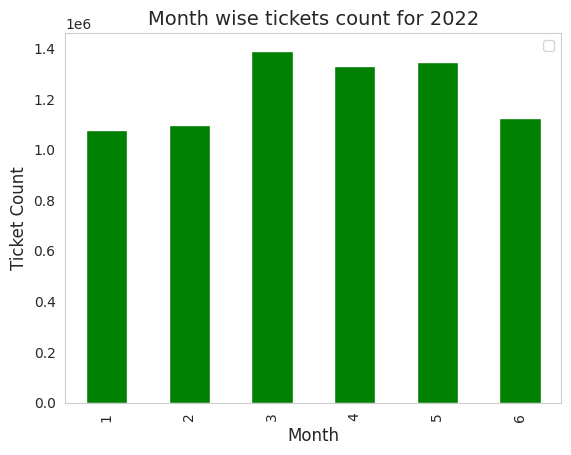

In [ ]:
# create a dataframe with the month wise tickets data

month_wise_tickets_df = month_wise_tickets.toPandas()

# plot a graph
plt.clf()
month_wise_tickets_df.plot(x= 'month', y='ticket_count', kind='bar', color='green')
plt.title('Month wise tickets count for 2022', fontsize = 14)
plt.xlabel("Month", fontsize = 12)
plt.ylabel("Ticket Count", fontsize = 12)
plt.legend('')
plt.show()

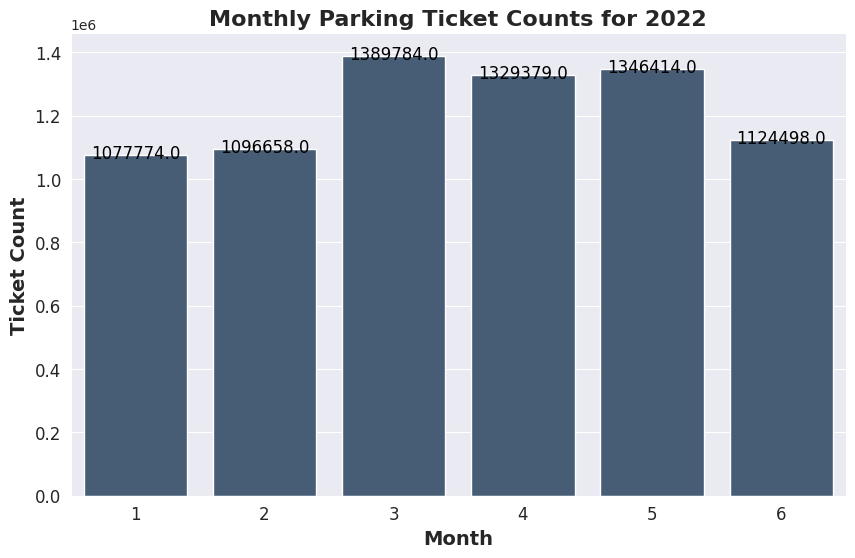

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# create a DataFrame from the Spark DataFrame
month_wise_tickets_df = month_wise_tickets.toPandas()

# set the figure size and style
plt.figure(figsize=(10, 6))
sns.set_style("darkgrid")

# create the bar plot
ax = sns.barplot(x="month", y="ticket_count", data=month_wise_tickets_df, color="#3F5D7D")

# customize the plot
ax.set_title("Monthly Parking Ticket Counts for 2022", fontsize=16, weight='bold')
ax.set_xlabel("Month", fontsize=14, weight='bold')
ax.set_ylabel("Ticket Count", fontsize=14, weight='bold')
ax.tick_params(labelsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# add labels to the bars
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x() + p.get_width() / 2, p.get_height() + 5000),
                ha='center', va='center', fontsize=12, color='black')

# show the plot
plt.show()


#4.2. Top 5 states that have maximum violations

<Figure size 640x480 with 0 Axes>

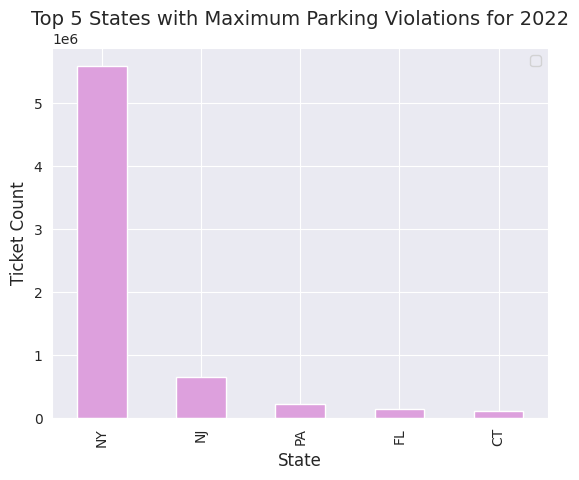

In [ ]:
# create a dataframe with the ragistered state wise tickets

registered_state_wise_tickets_df = registered_state_wise_tickets.toPandas()

# plot a graph
plt.clf()
registered_state_wise_tickets_df.head(5).plot(x='registration_state', y='ticket_count', kind='bar', color ='plum')
plt.title('Top 5 States with Maximum Parking Violations for 2022', fontsize = 14)
plt.xlabel("State", fontsize = 12)
plt.ylabel("Ticket Count", fontsize = 12)
plt.legend('')
plt.show()


#4.3. Top 5 Plate_Ids that have maximum violations

In [ ]:
# Top 5 Plate Ids with maximum violations

top_5_plate_ids = spark.sql("select Plate_ID as plate_id, count(*) as ticket_count \
                             from parking_2022 \
                             group by plate_id \
                             order by ticket_count desc \
                             limit 5")
top_5_plate_ids.show()

+--------+------------+
|plate_id|ticket_count|
+--------+------------+
| 40404JG|         657|
| 55219MM|         559|
| 2731057|         503|
| 82536PC|         453|
| 2871114|         438|
+--------+------------+



<Figure size 640x480 with 0 Axes>

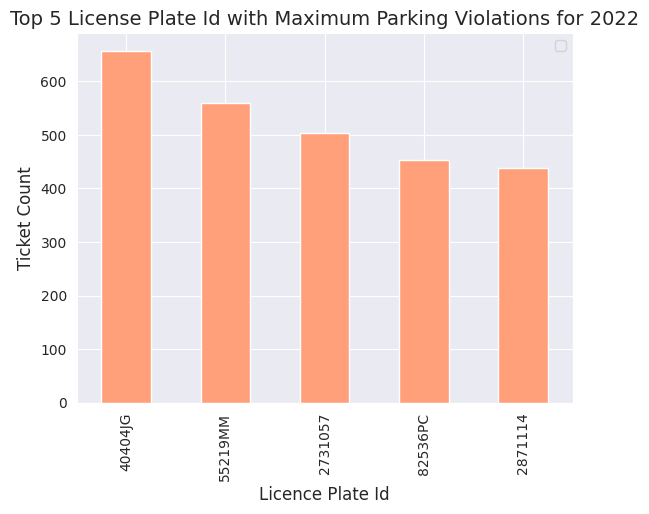

In [ ]:
# create a dataframe with the month wise tickets data

top_5_plate_ids_df = top_5_plate_ids.toPandas()

# plot a graph
plt.clf()
top_5_plate_ids_df.plot(x='plate_id', y='ticket_count', kind='bar', color='lightsalmon')
plt.title("Top 5 License Plate Id with Maximum Parking Violations for 2022", fontsize = 14)
plt.xlabel("Licence Plate Id", fontsize = 12)
plt.ylabel("Ticket Count", fontsize = 12)
plt.legend('')
plt.show()

In [ ]:
plateIDs = ["40404JG","55219MM","2731057","82536PC","2871114"]
plateTypes = parking2022.filter(col("plate_id").isin(plateIDs)) \
                      .select("plate_id", "plate_type") \
                      .collect()

#Step 5 : Examine the data
5.1. Find the total number of tickets for the year.

In [ ]:
# Total number of tickets for the year 2022

from pyspark.sql.functions import countDistinct
parking2022.select(countDistinct("Summons_Number").alias("total_number_of_tickets")).show()

+-----------------------+
|total_number_of_tickets|
+-----------------------+
|                7364889|
+-----------------------+



5.2. Find out the number of unique states from where the cars that got parking tickets came. (Hint: Use the column 'Registration State'.)


In [ ]:
from pyspark.sql.functions import countDistinct
parking2022.select(countDistinct("registration_State").alias("number_of_unique_states")).show()
#parking2022.select(distinct("registration_State")).show()

+-----------------------+
|number_of_unique_states|
+-----------------------+
|                     64|
+-----------------------+



In [ ]:
distinct_states = parking2022.select('Registration_State').distinct()
distinct_states.show()


+------------------+
|Registration_State|
+------------------+
|                NJ|
|                ME|
|                NY|
|                NC|
|                MA|
|                FL|
|                PA|
|                TX|
|                GA|
|                CO|
|                LA|
|                VA|
|                KY|
|                RI|
|                NH|
|                CT|
|                SC|
|                AZ|
|                MN|
|                DC|
+------------------+
only showing top 20 rows



In [ ]:
# Check the ticket counts based on registered state again and see if 10794 rows associated to state 99 has been now added to
# NY (4273951 + 10794 = 4284745)

registered_state_wise_tickets = spark.sql("select Registration_State as registration_state, count(*) as ticket_count \
                               from parking_2022 \
                               group by registration_state \
                               order by ticket_count desc")

registered_state_wise_tickets.show()

+------------------+------------+
|registration_state|ticket_count|
+------------------+------------+
|                NY|     5591980|
|                NJ|      656580|
|                PA|      229326|
|                FL|      146887|
|                CT|      115292|
|                TX|       71458|
|                IN|       62371|
|                MA|       48698|
|                GA|       47134|
|                VA|       45763|
|                NC|       41168|
|                MD|       39071|
|                CA|       28178|
|                IL|       23386|
|                OH|       21349|
|                AZ|       19180|
|                ME|       17071|
|                SC|       16864|
|                TN|       12638|
|                DE|       12331|
+------------------+------------+
only showing top 20 rows



In [ ]:
# Check the ticket counts based on registered state again and see if 10794 rows associated to state 99 has been now added to
# NY (4273951 + 10794 = 4284745)

registered_state_wise_tickets = spark.sql("select Registration_State as registration_state, count(*) as ticket_count \
                               from parking_2022 \
                               group by registration_state \
                               order by ticket_count desc")

registered_state_wise_tickets.show(100)

+------------------+------------+
|registration_state|ticket_count|
+------------------+------------+
|                NY|     5591980|
|                NJ|      656580|
|                PA|      229326|
|                FL|      146887|
|                CT|      115292|
|                TX|       71458|
|                IN|       62371|
|                MA|       48698|
|                GA|       47134|
|                VA|       45763|
|                NC|       41168|
|                MD|       39071|
|                CA|       28178|
|                IL|       23386|
|                OH|       21349|
|                AZ|       19180|
|                ME|       17071|
|                SC|       16864|
|                TN|       12638|
|                DE|       12331|
|                MN|       10197|
|                WA|        9195|
|                MI|        9103|
|                AL|        8885|
|                VT|        8318|
|                RI|        7521|
|             

In [ ]:
distinct_states = parking2022.select('Registration_State').distinct()
distinct_states.show(distinct_states.count(), False)


+------------------+
|Registration_State|
+------------------+
|NJ                |
|ME                |
|NY                |
|NC                |
|MA                |
|FL                |
|PA                |
|TX                |
|GA                |
|CO                |
|LA                |
|VA                |
|KY                |
|RI                |
|NH                |
|CT                |
|SC                |
|AZ                |
|MN                |
|DC                |
|OR                |
|NV                |
|CA                |
|VT                |
|MD                |
|IL                |
|WA                |
|MS                |
|AL                |
|IN                |
|OH                |
|TN                |
|IA                |
|NM                |
|AK                |
|OK                |
|UT                |
|NS                |
|WY                |
|BC                |
|MI                |
|GV                |
|QB                |
|WI                |
|ID          

The values "SK", "PE", "MB", and "FO" are likely abbreviations for provinces or territories in Canada. "SK" stands for Saskatchewan, "PE" stands for Prince Edward Island, "MB" stands for Manitoba, and "FO" could potentially stand for Newfoundland and Labrador. These abbreviations may be present in the data because the parking tickets were issued to vehicles registered in Canada.

There are a total of 62 unique rows in this table, including both US states and provinces/territories outside the US.

There are 50 US states mentioned in this table, and 12 provinces/territories outside the US (ON, QB, GV, DP, NS, AB, BC, NB, FO, MB, PE, SK).

From the table values above, the values of the abbreviations for provinces or territories outside the US are:

ON: Ontario, Canada
QB: Quebec, Canada
DP: Diplomatic (Foreign) Vehicles
GV: Government Vehicles
NS: Nova Scotia, Canada
AB: Alberta, Canada
BC: British Columbia, Canada
NB: New Brunswick, Canada
FO: Foreign Vehicles
MB: Manitoba, Canada
PE: Prince Edward Island, Canada
SK: Saskatchewan, Canada




Here is a list of US states and their full forms:

NY: New York
NJ: New Jersey
PA: Pennsylvania
FL: Florida
CT: Connecticut
TX: Texas
IN: Indiana
MA: Massachusetts
GA: Georgia
VA: Virginia
NC: North Carolina
MD: Maryland
CA: California
IL: Illinois
OH: Ohio
AZ: Arizona
ME: Maine
SC: South Carolina
TN: Tennessee
DE: Delaware
MN: Minnesota
WA: Washington
MI: Michigan
AL: Alabama
VT: Vermont
RI: Rhode Island
NH: New Hampshire
OK: Oklahoma
WI: Wisconsin
CO: Colorado
OR: Oregon
MS: Mississippi
MO: Missouri
KY: Kentucky
LA: Louisiana
DC: District of Columbia
AR: Arkansas
NV: Nevada
UT: Utah
IA: Iowa
MT: Montana
NM: New Mexico
KS: Kansas
NE: Nebraska
ID: Idaho
WY: Wyoming
ND: North Dakota
AK: Alaska
HI: Hawaii
And here are the full forms of some other regions that are not US states or territories:

ON: Ontario (a province of Canada)
QB: Quebec (a province of Canada)
GV: Guanajuato (a state in Mexico)
DP: Durango (a state in Mexico)
NS: Nova Scotia (a province of Canada)
AB: Alberta (a province of Canada)
BC: British Columbia (a province of Canada)
NB: New Brunswick (a province of Canada)
FO: Faroe Islands (an autonomous territory of Denmark)
MB: Manitoba (a province of Canada)
PE: Prince Edward Island (a province of Canada)
SK: Saskatchewan (a province of Canada)






#Step 6 : Aggregation Tasks
6.1. How often does each violation code occur? Display the frequency of the top five violation codes.

In [ ]:
# How often does each violation code occur? Display the frequency of the top five violation codes

violation_code_frequency = spark.sql("select Violation_Code as violation_code, count(*) as ticket_frequency \
                                      from parking_2022 \
                                      group by violation_code \
                                      order by ticket_frequency desc \
                                      limit 5")
violation_code_frequency.show()

+--------------+----------------+
|violation_code|ticket_frequency|
+--------------+----------------+
|            36|         2172974|
|            21|          781055|
|            38|          549389|
|            14|          460303|
|            40|          403276|
+--------------+----------------+





1.   36 -  Exceeding the posted speed limit in a school zone during the specified hours of operation, or failing to yield to pedestrians in a crosswalk within a school zone during school hours.
2.   21 - Street Cleaning: No Parking Where Parking is Normally Allowed Due to Street Cleaning.
3.  38 - Parking in front of a pedestrian ramp or within an access aisle for people with disabilities.
4.  14 - Parking in a truck loading zone without proper authorization or a commercial vehicle permit.
5. 40 - Parking in a bike lane, or creating an obstruction in a bike lane.

<Figure size 640x480 with 0 Axes>

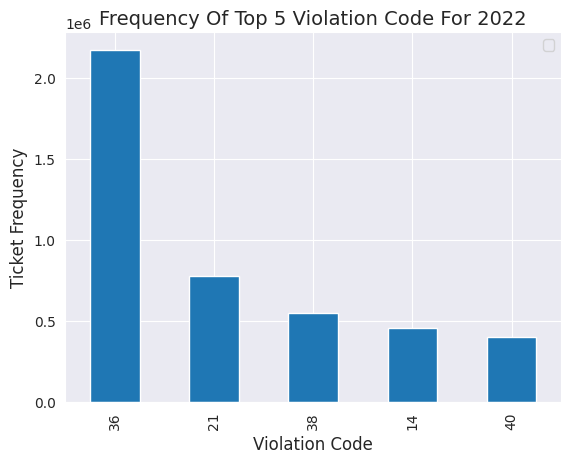

In [ ]:
# create a dataframe with the violation_code_frequency

violation_code_frequency_df = violation_code_frequency.toPandas()

# plot a graph
plt.clf()
violation_code_frequency_df.plot(x='violation_code', y='ticket_frequency', kind='bar')
plt.title('Frequency Of Top 5 Violation Code For 2022', fontsize = 14)
plt.xlabel("Violation Code", fontsize = 12)
plt.ylabel("Ticket Frequency", fontsize = 12)
plt.legend('')
plt.show()

6.2. How often does each 'vehicle body type' get a parking ticket? How about the 'vehicle make'? (Hint: Find the top 5 for both.)

In [ ]:
# Display the frequency of the top five Vehicle Body Type getting a parking ticket

vehicle_body_type_frequency = spark.sql("select Vehicle_Body_Type as vehicle_body_type, count(*) as ticket_frequency \
                                      from parking_2022 \
                                      group by vehicle_body_type \
                                      order by ticket_frequency desc \
                                      limit 5")

vehicle_body_type_frequency.show()

+-----------------+----------------+
|vehicle_body_type|ticket_frequency|
+-----------------+----------------+
|             SUBN|         3124187|
|             4DSD|         2077418|
|              VAN|          640294|
|             PICK|          212023|
|             DELV|          204294|
+-----------------+----------------+



<Figure size 640x480 with 0 Axes>

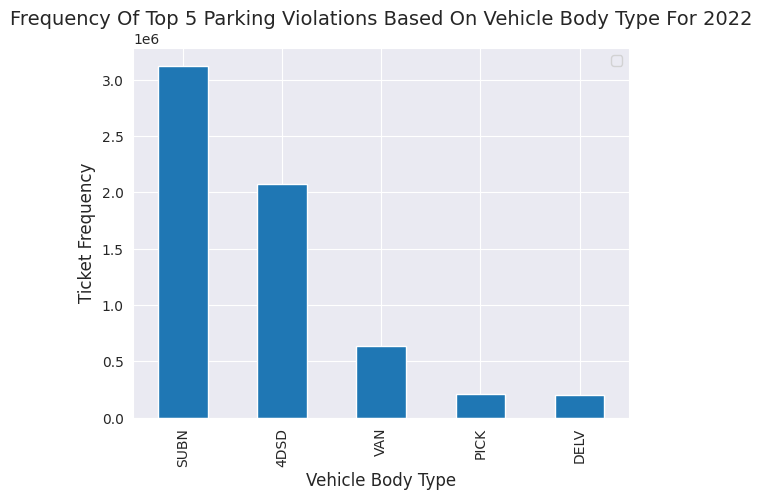

In [ ]:
# create a dataframe with the vehicle_body_type_frequency

vehicle_body_type_frequency_df = vehicle_body_type_frequency.toPandas()

# plot a graph
plt.clf()
vehicle_body_type_frequency_df.head(5).plot(x='vehicle_body_type', y='ticket_frequency', kind='bar')
plt.title('Frequency Of Top 5 Parking Violations Based On Vehicle Body Type For 2022', fontsize = 14)
plt.xlabel("Vehicle Body Type", fontsize = 12)
plt.ylabel("Ticket Frequency", fontsize = 12)
plt.legend('')
plt.show()


In [ ]:
# Display the frequency of the top five Vehicle Make getting a parking ticket

vehicle_make_ticket_frequency = spark.sql("select Vehicle_Make as vehicle_make, count(*) as ticket_frequency \
                                          from parking_2022 \
                                          group by vehicle_make \
                                          order by ticket_frequency desc \
                                          limit 5")
vehicle_make_ticket_frequency.show()


+------------+----------------+
|vehicle_make|ticket_frequency|
+------------+----------------+
|       HONDA|          892055|
|       TOYOT|          813451|
|        FORD|          703499|
|       NISSA|          622117|
|       CHEVR|          388320|
+------------+----------------+



<Figure size 640x480 with 0 Axes>

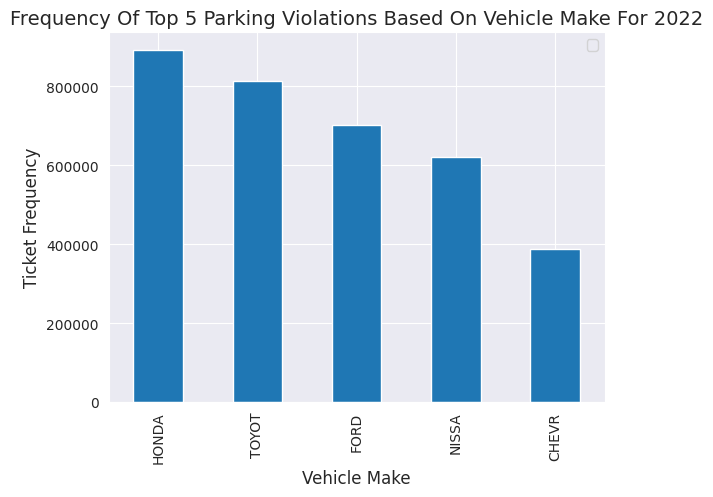

In [ ]:
# create a dataframe with the vehicle_make_ticket_frequency
vehicle_make_ticket_frequency_df = vehicle_make_ticket_frequency.toPandas()

# plot a graph
plt.clf()
vehicle_make_ticket_frequency_df.plot(x='vehicle_make', y='ticket_frequency', kind='bar')
plt.title('Frequency Of Top 5 Parking Violations Based On Vehicle Make For 2022', fontsize = 14)
plt.xlabel("Vehicle Make", fontsize = 12)
plt.ylabel("Ticket Frequency", fontsize = 12)
plt.legend('')
plt.show()

6.3. A precinct is a police station that has a certain zone of the city under its command. Find the (5 highest) frequencies of tickets for each of the following :
'Violation Precinct' (This is the precinct of the zone where the violation occurred). Using this, can you draw any insights for parking violations in any specific areas of the city?
'Issuer Precinct' (This is the precinct that issued the ticket.)
Here, you would have noticed that the dataframe has the'Violating Precinct' or 'Issuing Precinct' as '0'. These are erroneous entries. Hence, you need to provide the records for five correct precincts. (Hint: Print the top six entries after sorting.)

In [ ]:
# Display the frequency of the top five violation precinct

violation_precinct_ticket_frequency = spark.sql("select Violation_Precinct as violation_precinct, count(*) as ticket_frequency \
                                                from parking_2022 \
                                                group by violation_precinct \
                                                order by ticket_frequency desc")
violation_precinct_ticket_frequency.show(6)

+------------------+----------------+
|violation_precinct|ticket_frequency|
+------------------+----------------+
|                 0|         2700953|
|                19|          224703|
|               114|          180404|
|                13|          162145|
|                18|          154857|
|                14|          140062|
+------------------+----------------+
only showing top 6 rows



<Figure size 640x480 with 0 Axes>

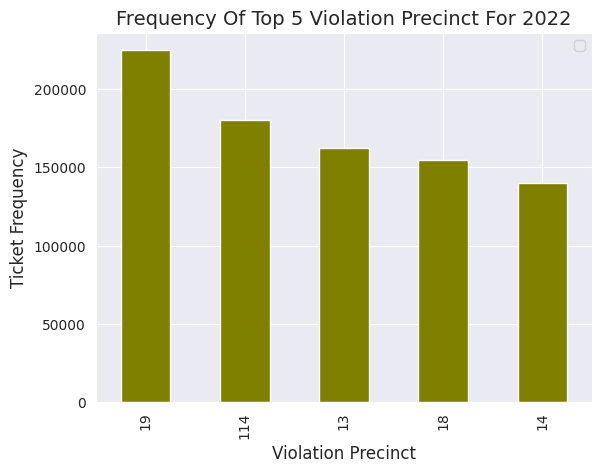

In [ ]:
# create a dataframe with the violation_precinct_ticket_frequency

violation_precinct_ticket_frequency_df = violation_precinct_ticket_frequency.toPandas()

# plot a graph
plt.clf()
violation_precinct_ticket_frequency_df[violation_precinct_ticket_frequency_df.violation_precinct != 0].head(5)\
                                        .plot(x='violation_precinct', y='ticket_frequency', kind='bar', color='olive')

plt.title('Frequency Of Top 5 Violation Precinct For 2022', fontsize = 14)
plt.xlabel("Violation Precinct", fontsize = 12)
plt.ylabel("Ticket Frequency", fontsize = 12)
plt.legend('')
plt.show()

In [ ]:
# Display the frequency of the top six issuer precinct

issuer_precinct_ticket_frequency = spark.sql("select Issuer_Precinct as issuer_precinct, count(*) as ticket_frequency \
                                                from parking_2022 \
                                                group by issuer_precinct \
                                                order by ticket_frequency desc")

issuer_precinct_ticket_frequency.show(6)

+---------------+----------------+
|issuer_precinct|ticket_frequency|
+---------------+----------------+
|              0|         2914218|
|             19|          221492|
|            114|          175466|
|             13|          159279|
|             18|          154754|
|             14|          139769|
+---------------+----------------+
only showing top 6 rows



0 - This is not a precinct code, but rather a prefix that is added to certain violation codes that are related to vehicle registration and inspection, such as "02" (No standing where standing is not allowed by sign, street marking, or traffic control device - no stopping/parking where prohibited by NYC DOF).

19 - Precinct located in the neighborhood of East New York in Brooklyn.

114 - Precinct located in the neighborhood of Rockaway Park in Queens.

13 - Precinct located in the neighborhood of East Flatbush in Brooklyn.

18 - Precinct located in the neighborhood of Morrisania in the Bronx.

14 - Precinct located in the neighborhoods of Red Hook and Sunset Park in Brooklyn.

<Figure size 640x480 with 0 Axes>

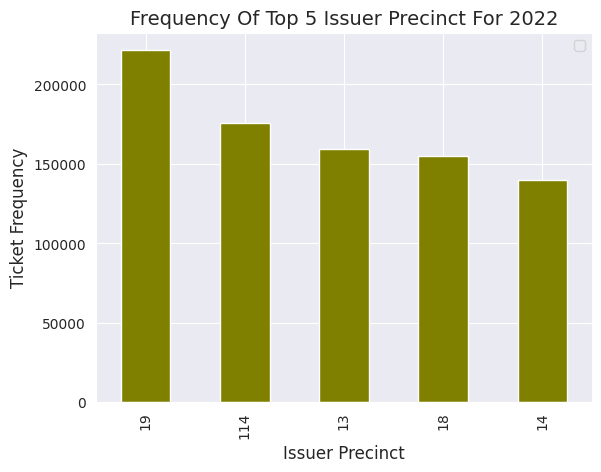

In [ ]:
# create a dataframe with the issuer_precinct_ticket_frequency

issuer_precinct_ticket_frequency_df = issuer_precinct_ticket_frequency.toPandas()

# plot a graph
plt.clf()
issuer_precinct_ticket_frequency_df[issuer_precinct_ticket_frequency_df.issuer_precinct != 0].head(5)\
                                        .plot(x='issuer_precinct', y='ticket_frequency', kind='bar', color='olive')

plt.title('Frequency Of Top 5 Issuer Precinct For 2022', fontsize = 14)
plt.xlabel("Issuer Precinct", fontsize = 12)
plt.ylabel("Ticket Frequency", fontsize = 12)
plt.legend('')
plt.show()

6.4. Find the violation code frequencies for three precincts that have issued the most number of tickets. Do these precinct zones have an exceptionally high frequency of certain violation codes? Are these codes common across precincts?
-(Hint: In the SQL view, use the 'where' attribute to filter among three precincts.)
Solution : From the results of the question above, it is clear that the three precincts that have issued the most number of tickets are 19, 14 and 1.Hence the violation code frequency for the three precincts are as given below :

In [ ]:
# Violation code Frquency for Issuer Precinct 19 

violation_code_frequency_precinct19 = spark.sql("select Violation_Code as violation_code, count(*) as ticket_frequency \
                                                from parking_2022 \
                                                where Issuer_Precinct = 19 \
                                                group by violation_code \
                                                order by ticket_frequency desc \
                                                limit 5 ")

violation_code_frequency_precinct19.show()

+--------------+----------------+
|violation_code|ticket_frequency|
+--------------+----------------+
|            38|           31070|
|            21|           27571|
|            14|           23899|
|            20|           22191|
|            40|           14652|
+--------------+----------------+



In [ ]:
 #Violation code Frquency for Issuer Precinct 114

violation_code_frequency_precinct14 = spark.sql("select Violation_Code as violation_code, count(*) as ticket_frequency \
                                                from parking_2022 \
                                                where Issuer_Precinct = 114 \
                                                group by violation_code \
                                                order by ticket_frequency desc \
                                                limit 5 ")

violation_code_frequency_precinct14.show()

+--------------+----------------+
|violation_code|ticket_frequency|
+--------------+----------------+
|            21|           39114|
|            38|           33761|
|            20|           15399|
|            40|           14255|
|            71|           13981|
+--------------+----------------+



In [ ]:
# Violation code Frquency for Issuer Precinct 13

violation_code_frequency_precinct1 = spark.sql("select Violation_Code as violation_code, count(*) as ticket_frequency \
                                                from parking_2022 \
                                                where Issuer_Precinct = 13 \
                                                group by violation_code \
                                                order by ticket_frequency desc \
                                                limit 5 ")

violation_code_frequency_precinct1.show()

+--------------+----------------+
|violation_code|ticket_frequency|
+--------------+----------------+
|            69|           24780|
|            31|           24395|
|            47|           17820|
|            14|           12718|
|            38|           11234|
+--------------+----------------+



In [ ]:
# Common violation Codes across issuer precincts 19, 114 and 13
_
common_precincts_violation_codes = spark.sql("select Violation_Code as violation_code , count(*) as ticket_frequency \
                                              from parking_2022 \
                                              where Issuer_Precinct in (19, 114, 13) \
                                              group by violation_code \
                                              order by ticket_frequency desc \
                                              limit 5 ")

common_precincts_violation_codes.show()

+--------------+----------------+
|violation_code|ticket_frequency|
+--------------+----------------+
|            38|           76065|
|            21|           73848|
|            20|           48363|
|            14|           43424|
|            31|           34506|
+--------------+----------------+



<Figure size 640x480 with 0 Axes>

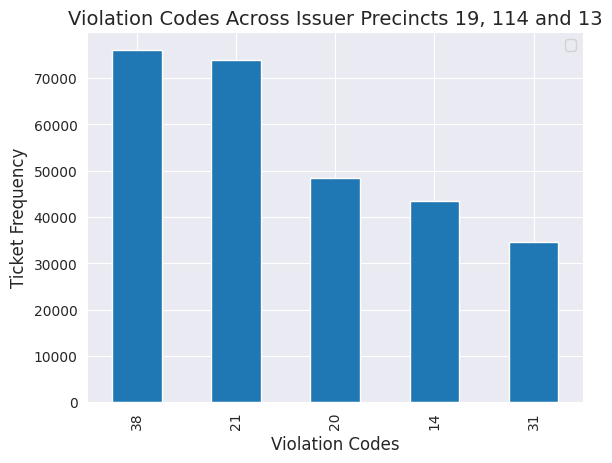

In [ ]:
# create a dataframe with the common_precincts_violation_codes

common_precincts_violation_codes_df = common_precincts_violation_codes.toPandas()

# plot a graph
plt.clf()
common_precincts_violation_codes_df.plot(x='violation_code', y='ticket_frequency', kind='bar')
plt.title('Violation Codes Across Issuer Precincts 19, 114 and 13', fontsize = 14)
plt.xlabel("Violation Codes", fontsize = 12)
plt.ylabel("Ticket Frequency", fontsize = 12)
plt.legend('')
plt.show()

Divide 24 hours into six equal discrete bins of time. Choose the intervals as you see fit. For each of these groups, find the three most commonly occurring violations.


In [ ]:
# Dividing the 24 hours into six equal discrete bins of time.

# We shall divide the 24 hours in the following bin category

#     Bin 1 = 12:00 AM to 4:00 AM
#     Bin 2 = 4:00 AM to 8:00 AM
#     Bin 3 = 8:00 AM to 12:00 PM
#     Bin 4 = 12:00 PM to 4:00 PM
#     Bin 5 = 4:00 PM to 8:00 PM
#     Bin 6 = 8:00 PM to 12:00 AM

violation_time_bins_2022_df = spark.sql("select Summons_Number, Violation_Code, Violation_Time, \
                                         case \
                                               when substring(Violation_Time,1,2) in ('12', '00','01','02','03') \
                                                       and upper(substring(Violation_Time,-1))='A' \
                                               then 1 \
                                               when substring(Violation_Time,1,2) in ('04','05','06','07') \
                                                       and upper(substring(Violation_Time,-1))='A' \
                                               then 2 \
                                               when substring(Violation_Time,1,2) in ('08','09','10','11') \
                                                       and upper(substring(Violation_Time,-1))='A' \
                                               then 3 \
                                               when substring(Violation_Time,1,2) in ('12','00','01','02','03') \
                                                       and upper(substring(Violation_Time,-1))='P' \
                                               then 4 \
                                               when substring(Violation_Time,1,2) in ('04','05','06','07') \
                                                       and upper(substring(Violation_Time,-1))='P' \
                                               then 5 \
                                               when substring(Violation_Time,1,2) in ('08','09','10','11') \
                                                       and upper(substring(Violation_Time,-1))='P' \
                                               then 6 \
                                               else null \
                                        end as Violation_Time_Bin \
                                        from parking_2022 \
                                        where Violation_Time is not null")

violation_time_bins_2022_df.show(10) 

+--------------+--------------+--------------+------------------+
|Summons_Number|Violation_Code|Violation_Time|Violation_Time_Bin|
+--------------+--------------+--------------+------------------+
|    1472427087|            46|         0238A|                 1|
|    1472133560|            78|         0154A|                 1|
|    1474450842|            46|         1150A|                 3|
|    1473476173|            14|         1252A|                 1|
|    1476043383|            20|         0815P|                 6|
|    1478293986|            14|         0331P|                 4|
|    1484274763|            14|         0620P|                 5|
|    1484277508|            14|         0637P|                 5|
|    1484365173|            98|         0322A|                 1|
|    1483869519|            50|         0502A|                 2|
+--------------+--------------+--------------+------------------+
only showing top 10 rows



In [ ]:
# Create/Replace a Temp View

violation_time_bins_2022_df.createOrReplaceTempView("violation_time_bins_2022")


In [ ]:
# Three most commonly occuring violation codes for bin 1 i.e between 12:00 AM to 4:00 AM

violation_time_bin1 = spark.sql("select Violation_Code as violation_code, count(*) as violation_count \
                                 from violation_time_bins_2022 \
                                 where Violation_Time_Bin == 1 \
                                 group by violation_code \
                                 order by violation_count desc \
                                 limit 3 ")
violation_time_bin1.show()

+--------------+---------------+
|violation_code|violation_count|
+--------------+---------------+
|            21|          24903|
|            40|          23536|
|             7|          13239|
+--------------+---------------+



In [ ]:
# Three most commonly occuring violation codes for bin 2 i.e between 4:00 AM to 8:00 AM

violation_time_bin2 = spark.sql("select Violation_Code as violation_code, count(*) as violation_count \
                                 from violation_time_bins_2022 \
                                 where Violation_Time_Bin == 2 \
                                 group by violation_code \
                                 order by violation_count desc \
                                 limit 3 ")
violation_time_bin2.show()

+--------------+---------------+
|violation_code|violation_count|
+--------------+---------------+
|            36|         199394|
|            40|         118172|
|            14|          91631|
+--------------+---------------+



In [ ]:
# Three most commonly occuring violation codes for bin 3 i.e between 8:00 AM to 12:00 PM

violation_time_bin3 = spark.sql("select Violation_Code as violation_code, count(*) as violation_count \
                                 from violation_time_bins_2022 \
                                 where Violation_Time_Bin == 3 \
                                 group by violation_code \
                                 order by violation_count desc \
                                 limit 3 ")
violation_time_bin3.show()

+--------------+---------------+
|violation_code|violation_count|
+--------------+---------------+
|            21|         606135|
|            36|         559645|
|            38|         221069|
+--------------+---------------+



In [ ]:
# Three most commonly occuring violation codes for bin 4 i.e between 12:00 PM to 4:00 PM

violation_time_bin4 = spark.sql("select Violation_Code as violation_code, count(*) as violation_count \
                                 from violation_time_bins_2022 \
                                 where Violation_Time_Bin == 4 \
                                 group by violation_code \
                                 order by violation_count desc \
                                 limit 3 ")
violation_time_bin4.show()

+--------------+---------------+
|violation_code|violation_count|
+--------------+---------------+
|            36|         636497|
|            38|         242621|
|            20|         136992|
+--------------+---------------+



In [ ]:
# Three most commonly occuring violation codes for bin 5 i.e between 4:00 PM to 8:00 PM

violation_time_bin5 = spark.sql("select Violation_Code as violation_code, count(*) as violation_count \
                                 from violation_time_bins_2022 \
                                 where Violation_Time_Bin == 5 \
                                 group by violation_code \
                                 order by violation_count desc \
                                 limit 3 ")
violation_time_bin5.show()

+--------------+---------------+
|violation_code|violation_count|
+--------------+---------------+
|            36|         543529|
|             5|          90874|
|            38|          61361|
+--------------+---------------+



In [ ]:
# Three most commonly occuring violation codes for bin 6 i.e between 8:00 PM to 12:00 AM

violation_time_bin6 = spark.sql("select Violation_Code as violation_code, count(*) as violation_count \
                                 from violation_time_bins_2022 \
                                 where Violation_Time_Bin == 6 \
                                 group by violation_code \
                                 order by violation_count desc \
                                 limit 3 ")
violation_time_bin6.show()

+--------------+---------------+
|violation_code|violation_count|
+--------------+---------------+
|            36|         233908|
|             7|          30969|
|            40|          28792|
+--------------+---------------+



In [ ]:
# Now, Let us find the 3 most commonly occuring violation codes amongst all the 6 bins.

common_violation_codes_across_bins = spark.sql("select Violation_Code as violation_code , count(*) as violation_count \
                                                from violation_time_bins_2022 \
                                                where violation_code in (21, 40, 78, 14, 40, 36, 38, 37, 7,5,20) \
                                                and Violation_Time != ''\
                                                group by violation_code \
                                                order by violation_count desc \
                                                limit 3 ")

common_violation_codes_across_bins.show()

+--------------+---------------+
|violation_code|violation_count|
+--------------+---------------+
|            36|        2172974|
|            21|         781055|
|            38|         549389|
+--------------+---------------+



6.5.3. Now, try another direction. For the three most commonly occurring violation codes, find the most common time of the day (in terms of the bins from the previous part).


In [ ]:
# For the three most commonly occurring violation codes, find the most common time of the day (in terms of the bins from the 
# previous part

common_time_for_violation = spark.sql("select Violation_Time_bin as violation_time_bin, count(*) as violation_count \
                                       from violation_time_bins_2022 \
                                       where Violation_Code in (21, 36, 38) \
                                       group by Violation_Time_bin \
                                       order by violation_count desc")
common_time_for_violation.show(6)

+------------------+---------------+
|violation_time_bin|violation_count|
+------------------+---------------+
|                 3|        1386849|
|                 4|         962923|
|                 5|         605139|
|                 2|         270772|
|                 6|         252819|
|                 1|          24913|
+------------------+---------------+
only showing top 6 rows



3 - 8.00 AM to 12.00 PM

1 - 12.00 AM to 4.00 AM

# 6.6.1. Divide the year into a certain number of seasons, and find the frequencies of tickets for each season.

In [ ]:
# First let us divide the year into seasons based on the Issue Date

# We shall divide the 4 seasons based on Issue Date as follows

#     Spring = March to May
#     Summer = June to August
#     Autumn = September to November
#     winter = December to February

seasons2022 = spark.sql("select Summons_Number, Issue_Date, Violation_Code,  \
                        case \
                            when MONTH(TO_DATE(Issue_Date, 'MM/dd/yyyy')) between 03 and 05 \
                                then 'spring' \
                            when MONTH(TO_DATE(Issue_Date, 'MM/dd/yyyy')) between 06 and 08 \
                                then 'summer' \
                            when MONTH(TO_DATE(Issue_Date, 'MM/dd/yyyy')) between 09 and 11 \
                                then 'autumn' \
                            when MONTH(TO_DATE(Issue_Date, 'MM/dd/yyyy')) in (1,2,12) \
                                then 'winter' \
                            else 'unknown' \
                        end as Season \
                        from parking_2022")

seasons2022.show(10)

+--------------+----------+--------------+------+
|Summons_Number|Issue_Date|Violation_Code|Season|
+--------------+----------+--------------+------+
|    1472427087|07/18/2022|            46|summer|
|    1472133560|07/01/2022|            78|summer|
|    1474450842|07/14/2022|            46|summer|
|    1473476173|07/05/2022|            14|summer|
|    1476043383|07/02/2022|            20|summer|
|    1478293986|07/20/2022|            14|summer|
|    1484274763|07/04/2022|            14|summer|
|    1484277508|02/04/2022|            14|winter|
|    1484365173|07/16/2022|            98|summer|
|    1483869519|07/18/2022|            50|summer|
+--------------+----------+--------------+------+
only showing top 10 rows



In [ ]:
# Create/Replace a Temp View

seasons2022.createOrReplaceTempView("seasons_2022")

In [ ]:
# Frequency of tickets based on season

parking_violations_on_seasons = spark.sql("select Season as season, count(*) as ticket_frequency \
                                           from seasons_2022 \
                                           group by season \
                                           order by ticket_frequency desc")
parking_violations_on_seasons.show()

+------+----------------+
|season|ticket_frequency|
+------+----------------+
|spring|         4065577|
|winter|         2174542|
|summer|         1124593|
|autumn|             177|
+------+----------------+



Autum is a tourist wid dowN period

In [ ]:
#6.6.2. Find the three most common violations for each of these seasons.

In [ ]:
# Three most commonly occuring violation for spring i.e. from March to May

spring = spark.sql("select Violation_Code as violation_code, count(*) as violation_count \
                    from seasons_2022 \
                    where Season == 'spring' \
                    group by violation_code \
                    order by violation_count desc \
                    limit 3 ")
spring.show()

In [ ]:
# Three most commonly occuring violation for winter i.e. from December to February

winter = spark.sql("select Violation_Code as violation_code, count(*) as violation_count \
                    from seasons_2022 \
                    where Season == 'winter' \
                    group by violation_code \
                    order by violation_count desc \
                    limit 3 ")
winter.show()

+--------------+---------------+
|violation_code|violation_count|
+--------------+---------------+
|            36|         700174|
|            21|         192766|
|            38|         157576|
+--------------+---------------+



In [ ]:
# Three most commonly occuring violation for summer i.e. from June to September

summer = spark.sql("select Violation_Code as violation_code, count(*) as violation_count \
                    from seasons_2022 \
                    where Season == 'summer' \
                    group by violation_code \
                    order by violation_count desc \
                    limit 3 ")
summer.show()

+--------------+---------------+
|violation_code|violation_count|
+--------------+---------------+
|            36|         336455|
|            21|         151927|
|            38|          84705|
+--------------+---------------+



In [ ]:
# Three most commonly occuring violation for autumn i.e. from September to November

autumn = spark.sql("select Violation_Code as violation_code, count(*) as violation_count \
                    from seasons_2022 \
                    where Season == 'autumn' \
                    group by violation_code \
                    order by violation_count desc \
                    limit 3 ")
autumn.show()

+--------------+---------------+
|violation_code|violation_count|
+--------------+---------------+
|            98|             38|
|            40|             36|
|            46|             28|
+--------------+---------------+



6.7. The fines collected from all the instances of parking violation constitute a source of revenue for the NYC Police Department. Let’s take an example of estimating this for the three most commonly occurring codes:
- Find the total occurrences of the three most common violation codes.      
- Then, visit the website: http://www1.nyc.gov/site/finance/vehicles/services-violation-codes.page
  It lists the fines associated with different violation codes. They’re divided into two categories: one for 
  the highest-density locations in the city and the other for the rest of the city. For the sake of simplicity, 
  take the average of the two.
- Using this information, find the total amount collected for the three violation codes with the maximum tickets.
  State the code that has the highest total collection.
- What can you intuitively infer from these findings?

In [ ]:
#6.7.1 Find the total occurrences of the three most common violation codes.
top_3_common_violations = spark.sql("select Violation_Code as violation_code, count(*) as ticket_frequency \
                                    from parking_2022 \
                                    group by violation_code \
                                    order by ticket_frequency desc \
                                    limit 3")
top_3_common_violations.show()

+--------------+----------------+
|violation_code|ticket_frequency|
+--------------+----------------+
|            36|         2172974|
|            21|          781055|
|            38|          549389|
+--------------+----------------+



In [ ]:
#6.7.2 Find the total amount collected for the three violation codes with maximum tickets. State the code that has the highest total collection
# From the above result we know the top three violation codes.

# As per the website, the average prices for the three violation codes are as follows:
#   For violation code 21 = (65 + 45)/2 = $55
#   For violation code 36 = (50 + 50)/2 = $50
#   For violation code 38 = (65 + 35)/2 = $50

from pyspark.sql.functions import when

common_violations_fine_amount = top_3_common_violations \
                                .withColumn("fine_amount",when(top_3_common_violations.violation_code == 21, \
                                (top_3_common_violations.ticket_frequency) *55) \
                                .otherwise((top_3_common_violations.ticket_frequency)*50))

common_violations_fine_amount.show()

+--------------+----------------+-----------+
|violation_code|ticket_frequency|fine_amount|
+--------------+----------------+-----------+
|            36|         2172974|  108648700|
|            21|          781055|   42958025|
|            38|          549389|   27469450|
+--------------+----------------+-----------+



In [ ]:
# Total amount collected for the three violation codes with maximum tickets

from pyspark.sql import functions as F

total = common_violations_fine_amount.agg(F.sum("fine_amount")).collect()
print('Total amount collected for the three violation codes with maximum tickets : ', total)

Total amount collected for the three violation codes with maximum tickets :  [Row(sum(fine_amount)=179076175)]


In [ ]:
# State the code that has the highest total collection

common_violations_fine_amount.show(1)

+--------------+----------------+-----------+
|violation_code|ticket_frequency|fine_amount|
+--------------+----------------+-----------+
|            36|         2172974|  108648700|
+--------------+----------------+-----------+
only showing top 1 row



In [ ]:
#spark.stop()